# HomeMatch - Multimodal Real Estate Personalization

Future Homes Realty wants every buyer to feel like listings were written just for them. This notebook assembles **LangChain**, **ChromaDB**, CLIP-based multimodal search, and GPT-powered narrative rewriting so that high-tech buyers shuttling between Berlin and Tokyo can discover homes that match their vibe.

## Project Roadmap
- configure the Vocareum / OpenAI client plus helper paths
- generate or load LLM-authored listings (>=10) and synthesize placeholder images
- build dual indexes: HuggingFace text embeddings inside Chroma and CLIP image embeddings inside a dedicated collection
- capture buyer intent via a question set tailored to high-tech labs, Joypolis nights, airsoft arenas, and waterfront parks
- run multimodal retrieval that blends semantic + visual scores
- personalize the top matches with LangChain prompts (or a local fallback when the key is missing) and display example outputs

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"
print("key seen?", bool(os.getenv("OPENAI_API_KEY")))


key seen? True


In [2]:
# import os

# voc_key = os.getenv("OPENAI_API_KEY")
# if not voc_key:
#     raise RuntimeError("Set OPENAI_API_KEY in your shell before running the notebook.")
# os.environ["OPENAI_API_KEY"] = voc_key
# os.environ["OPENAI_API_BASE"] = os.getenv("OPENAI_API_BASE", "https://openai.vocareum.com/v1")



In [ ]:
import json
import os
import random
import shutil
import textwrap
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import pandas as pd
import torch
from PIL import Image, ImageDraw, ImageFont

try:
    from langchain_openai import ChatOpenAI
except ImportError:
    from langchain.chat_models import ChatOpenAI

try:
    from langchain_core.prompts import ChatPromptTemplate
except ImportError:
    from langchain.prompts import ChatPromptTemplate

try:
    from langchain_core.output_parsers import PydanticOutputParser
except ImportError:
    from langchain.output_parsers import PydanticOutputParser

try:
    from langchain_community.vectorstores import Chroma
    from langchain_community.embeddings import HuggingFaceEmbeddings
    from langchain_community.docstore.document import Document
except ImportError:
    from langchain.vectorstores import Chroma
    from langchain.embeddings import HuggingFaceEmbeddings
    from langchain.docstore.document import Document

from pydantic import BaseModel, Field
from transformers import CLIPModel, CLIPProcessor
import chromadb
import uuid

try:
    from langchain.schema import OutputParserException
except ImportError:
    from langchain_core.exceptions import OutputParserException

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

PROJECT_ROOT = Path.cwd()
LISTINGS_DIR = PROJECT_ROOT / "listings"
IMAGE_DIR = LISTINGS_DIR / "images"
VECTOR_DB_DIR = LISTINGS_DIR / "vectorstores"
for path in (LISTINGS_DIR, IMAGE_DIR, VECTOR_DB_DIR):
    path.mkdir(parents=True, exist_ok=True)

LISTINGS_FILE = LISTINGS_DIR / "listings.json"
TEXT_VECTOR_DIR = VECTOR_DB_DIR / "text-chroma"
IMAGE_VECTOR_DIR = VECTOR_DB_DIR / "image-chroma"
VOC_BASE_URL = "https://openai.vocareum.com/v1"
# os.environ.setdefault("OPENAI_API_BASE", VOC_BASE_URL)

print(f"Project root: {PROJECT_ROOT}")
print(f"Listings source: {LISTINGS_FILE}")

Project root: c:\Users\Ohara\Desktop\__Udacity\generative_ai\personalized_real-estate_agent
Listings source: c:\Users\Ohara\Desktop\__Udacity\generative_ai\personalized_real-estate_agent\listings\listings.json


### OpenAI / LangChain helper

In [4]:
def maybe_build_llm(model_name: str = "gpt-3.5-turbo-0125", temperature: float = 0.35, max_tokens: int = 900):
    """Create a LangChain ChatOpenAI client when the Vocareum key is available."""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("Warning: set OPENAI_API_KEY (Vocareum) to enable live LLM calls. Falling back to on-device templates.")
        return None

    return ChatOpenAI(
        model=model_name,
        temperature=temperature,
        max_tokens=max_tokens,
        openai_api_key=api_key,
        openai_api_base=os.getenv("OPENAI_API_BASE", VOC_BASE_URL),
    )

## Listing schema and LLM generation

In [5]:
class Listing(BaseModel):
    listing_id: str = Field(..., description="Unique identifier, e.g., HM-BER-01")
    city: str
    neighborhood: str
    price: float
    currency: str = "EUR"
    bedrooms: int
    bathrooms: int
    size_sqft: int
    lot_size_sqft: int
    energy_score: str = "A"
    amenities: List[str]
    transit: List[str]
    technology_features: List[str]
    description: str
    neighborhood_description: str
    visual_prompt: str
    vibe_tags: List[str] = Field(default_factory=list)
    image_path: Optional[str] = None


class ListingBatch(BaseModel):
    listings: List[Listing]

In [6]:
listing_parser = PydanticOutputParser(pydantic_object=ListingBatch)
listing_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are Future Homes Realty's research assistant. Generate imaginative yet factual-ready listings for tech-forward buyers. "
     "Respond with JSON that follows:\n{format_instructions}\n"
     "Rules: keep price numbers realistic for Berlin or Tokyo, never invent impossible amenities (flying cars). Add a visual_prompt per listing "
     "that could guide CLIP image generation, and sprinkle vibe_tags that capture the setting."),
    ("human",
     "Produce {num_listings} listings rooted in Berlin (Mitte, Adlershof, Kreuzberg, Siemensstadt, Prenzlauer Berg, Tempelhof) and "
     "Tokyo's bayfront tech districts (Odaiba, Ariake, Shinonome, Takeshiba, Toyosu, Akihabara). Each listing should highlight transit options, "
     "maker-friendly amenities, and proximity to cultural playgrounds like Futurium, teamLab Borderless, Joypolis, or airsoft arenas."
    ),
])

CITY_COLOR_MAP = {
    "Berlin": ((24, 32, 56), (35, 120, 120), (180, 215, 130)),
    "Tokyo": ((12, 20, 40), (90, 140, 220), (240, 190, 80)),
}

FONT_CACHE = ImageFont.load_default()


def generate_listings_with_llm(llm: Optional[ChatOpenAI], num_listings: int = 12, max_retries: int = 3) -> List[Listing]:
    if llm is None:
        raise RuntimeError("LLM required to regenerate listings. Provide OPENAI_API_KEY to continue.")

    prompt = listing_prompt.partial(format_instructions=listing_parser.get_format_instructions())
    last_error = None
    for attempt in range(1, max_retries + 1):
        response = llm.invoke(prompt.format_messages(num_listings=num_listings))
        try:
            batch = listing_parser.parse(response.content)
            return batch.listings
        except OutputParserException as exc:
            last_error = exc
            print(f"Parse attempt {attempt} failed: {exc}. Retrying...")
    raise RuntimeError(f"LLM failed to produce valid listings after {max_retries} attempts: {last_error}")


def load_or_generate_listings(llm: Optional[ChatOpenAI], regenerate: bool = False, num_listings: int = 12) -> List[Listing]:
    if LISTINGS_FILE.exists() and not regenerate:
        data = json.loads(LISTINGS_FILE.read_text())
        return [Listing(**item) for item in data]

    listings = generate_listings_with_llm(llm, num_listings=num_listings)
    LISTINGS_FILE.write_text(json.dumps([listing.dict() for listing in listings], indent=2))
    return listings


def create_listing_image(listing: Listing) -> Path:
    image_path = IMAGE_DIR / f"{listing.listing_id}.png"
    if image_path.exists():
        return image_path

    base, mid, top = CITY_COLOR_MAP.get(listing.city, CITY_COLOR_MAP["Berlin"])
    w, h = 768, 512
    background = Image.new("RGB", (w, h), base)
    grad = Image.new("RGB", (w, h))
    grad_draw = ImageDraw.Draw(grad)
    for y in range(h):
        blend = tuple(int(mid[idx] * (1 - y / h) + top[idx] * (y / h)) for idx in range(3))
        grad_draw.line([(0, y), (w, y)], fill=blend)
    img = Image.blend(background, grad, alpha=0.55)
    draw = ImageDraw.Draw(img)
    draw.rectangle([20, 20, w - 20, h - 20], outline=(255, 255, 255), width=2)
    header = f"{listing.city} | {listing.neighborhood}"[:64]
    draw.text((40, 40), header, font=FONT_CACHE, fill=(255, 255, 255))

    def draw_wrapped(text: str, start_y: int, color, max_chars: int, max_lines: int) -> int:
        lines = textwrap.wrap(text, width=max_chars) or ["?"]
        for idx, line in enumerate(lines[:max_lines]):
            draw.text((40, start_y + idx * 26), line, font=FONT_CACHE, fill=color)
        return start_y + min(len(lines), max_lines) * 26

    next_y = draw_wrapped(", ".join(listing.vibe_tags), 80, (200, 220, 255), 30, 2)
    draw_wrapped(listing.visual_prompt, next_y + 10, (180, 205, 255), 42, 3)
    img.save(image_path)
    return image_path


def ensure_listing_images(listings: List[Listing]) -> None:
    for listing in listings:
        image_path = create_listing_image(listing)
        listing.image_path = str(image_path)

### Load cached listings (or regenerate with GPT)

In [7]:
REGENERATE_LISTINGS = False  # flip to True to call the LLM and overwrite listings.json
llm = maybe_build_llm()
listings = load_or_generate_listings(llm, regenerate=REGENERATE_LISTINGS, num_listings=12)
ensure_listing_images(listings)
listing_lookup = {listing.listing_id: listing for listing in listings}

preview_rows = [
    {
        "id": listing.listing_id,
        "city": listing.city,
        "neighborhood": listing.neighborhood,
        "price": f"{listing.price:,.0f} {listing.currency}",
        "beds/baths": f"{listing.bedrooms}/{listing.bathrooms}",
        "tech highlights": ", ".join(listing.technology_features[:2]),
        "transit": ", ".join(listing.transit[:2]),
        "vibe": ", ".join(listing.vibe_tags),
    }
    for listing in listings
]
preview_df = pd.DataFrame(preview_rows)
preview_df.head(8)

,id,city,neighborhood,price,beds/baths,tech highlights,transit,vibe
0,HM-BER-01,Berlin,Mitte Tech Quay,"1,180,000 EUR",3/2,"1 Tbps quantum-ready fiber, biometric access l...","U6 Stadtmitte, S3 Friedrichstrasse","riverfront, gallery-district, cyberpunk"
1,HM-BER-02,Berlin,Adlershof Science Spine,"890,000 EUR",4/3,"modular robotics rail, autonomous parcel lobby","S45 Adlershof, Tram 61","campus, green-corridor, maker-space"
2,HM-BER-03,Berlin,Kreuzberg Landwehrkanal Edge,"1,320,000 EUR",3/2,"5G private mesh, smart glass privacy clouds","U1 Schlesisches Tor, M29 express bus","waterfront, street-art, night-market"
3,HM-BER-04,Berlin,Siemensstadt Mobility Campus,"1,045,000 EUR",4/3,"digital twin HVAC, robotic herb wall","U7 Rohrdamm, Siemens Mobility hydrogen shuttle","industrial-chic, river-access, mobility"
4,HM-BER-05,Berlin,Prenzlauer Berg EDGE Hub,"970,000 EUR",3/2,"privacy-tuned acoustic cloud, circadian light ...","U2 Eberswalder Str, M2 tram","market-life, family-friendly, light-filled"
5,HM-BER-06,Berlin,Tempelhofer Hangar Lofts,"1,430,000 EUR",4/3,"runway-length solar array, rainwater lab","U6 Platz der Luftbrucke, Tempelhof cycling loop","open-space, heritage, sports-tech"
6,HM-TYO-01,Tokyo,Odaiba Palette Promenade,"210,000,000 JPY",3/2,"6G-enabled glass facade, robotic housekeeper rail","Yurikamome Daiba, Rinkai Tokyo Teleport","waterfront, future-park, nightlife"
7,HM-TYO-02,Tokyo,Ariake Garden Skycourts,"192,000,000 JPY",4/3,"drone landing halo, intelligent mist cooling","Yurikamome Ariake, Ariake Tennis Forest monorail","canal, sports-tech, panoramic"


## Text embeddings plus Chroma vector store

In [8]:
text_embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"},
)


def build_text_vector_store(listings: List[Listing], persist_dir: Path = TEXT_VECTOR_DIR) -> Chroma:
    target_dir = persist_dir
    if target_dir.exists():
        try:
            shutil.rmtree(target_dir)
        except OSError as exc:
            alt = target_dir.parent / f"{target_dir.name}-{uuid.uuid4().hex[:8]}"
            print(f"Warning: could not clear {target_dir} ({exc}). Using {alt} instead.")
            target_dir = alt

    documents = []
    for listing in listings:
        content = textwrap.dedent(f"""
        Listing {listing.listing_id} in {listing.city} ({listing.neighborhood}).
        Bedrooms/Bathrooms: {listing.bedrooms}/{listing.bathrooms}, size {listing.size_sqft} sqft.
        Amenities: {', '.join(listing.amenities)}.
        Technology: {', '.join(listing.technology_features)}.
        Transit: {', '.join(listing.transit)}.
        Description: {listing.description}
        Neighborhood: {listing.neighborhood_description}
        Vibes: {', '.join(listing.vibe_tags)}
        """).strip()
        metadata = {
            "listing_id": listing.listing_id,
            "city": listing.city,
            "neighborhood": listing.neighborhood,
            "beds": listing.bedrooms,
            "baths": listing.bathrooms,
            "price": listing.price,
            "currency": listing.currency,
        }
        documents.append(Document(page_content=content, metadata=metadata))

    store = Chroma.from_documents(
        documents=documents,
        embedding=text_embedder,
        persist_directory=str(target_dir),
    )
    return store

C:\Users\Ohara\AppData\Local\Temp\ipykernel_13024\95334555.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  text_embedder = HuggingFaceEmbeddings(


## CLIP image embeddings for multimodal search

In [9]:
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
clip_model.eval()


def compute_image_embedding(image: Image.Image) -> np.ndarray:
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
    features = features / features.norm(p=2, dim=-1, keepdim=True)
    return features.cpu().numpy()[0]


def compute_text_embedding(prompt: str) -> np.ndarray:
    inputs = clip_processor(text=[prompt], padding=True, return_tensors="pt")
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
    features = features / features.norm(p=2, dim=-1, keepdim=True)
    return features.cpu().numpy()[0]


class ImageVectorIndex:
    def __init__(self, collection):
        self.collection = collection

    @classmethod
    def build(cls, listings: List[Listing], persist_dir: Path = IMAGE_VECTOR_DIR, collection_name: str = "listing_images") -> "ImageVectorIndex":
        target_dir = persist_dir
        if target_dir.exists():
            try:
                shutil.rmtree(target_dir)
            except OSError as exc:
                alt = target_dir.parent / f"{target_dir.name}-{uuid.uuid4().hex[:8]}"
                print(f"Warning: could not clear {target_dir} ({exc}). Using {alt} instead.")
                target_dir = alt
        target_dir.mkdir(parents=True, exist_ok=True)

        client = chromadb.PersistentClient(path=str(target_dir))
        try:
            client.delete_collection(collection_name)
        except Exception:
            pass
        collection = client.create_collection(collection_name)

        ids, embeddings, metadatas, documents = [], [], [], []
        for listing in listings:
            if not listing.image_path:
                continue
            image = Image.open(listing.image_path).convert("RGB")
            vector = compute_image_embedding(image)
            ids.append(listing.listing_id)
            embeddings.append(vector.tolist())
            metadatas.append(
                {
                    "listing_id": listing.listing_id,
                    "city": listing.city,
                    "neighborhood": listing.neighborhood,
                    "image_path": listing.image_path,
                }
            )
            documents.append(listing.visual_prompt)

        if ids:
            collection.add(ids=ids, embeddings=embeddings, metadatas=metadatas, documents=documents)
        return cls(collection=collection)

    def search(self, prompt: str, top_k: int = 5) -> List[Dict[str, Any]]:
        query_vector = compute_text_embedding(prompt).tolist()
        result = self.collection.query(
            query_embeddings=[query_vector], n_results=top_k, include=["metadatas", "distances"]
        )
        hits = []
        metas = result.get("metadatas", [[]])[0]
        distances = result.get("distances", [[]])[0]
        for metadata, distance in zip(metas, distances):
            score = 1 / (1 + distance)
            hits.append(
                {
                    "listing_id": metadata["listing_id"],
                    "score": score,
                    "metadata": metadata,
                }
            )
        return hits


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Buyer preference survey (high-tech persona)

In [10]:
@dataclass
class PreferenceProfile:
    persona_name: str
    summary: str
    priorities: List[str]
    transit_story: str
    cultural_musts: List[str]
    visual_prompt: str
    raw_answers: Dict[str, str]

    def to_text_query(self) -> str:
        return textwrap.dedent(
            f"""
            {self.summary}
            Priorities: {', '.join(self.priorities)}.
            Transit: {self.transit_story}.
            Culture: {', '.join(self.cultural_musts)}.
            Visual tone: {self.visual_prompt}.
            """
        ).strip()


class PreferenceSurvey:
    def __init__(self) -> None:
        self.questions = [
            "Which future-friendly districts or cities should we prioritize?",
            "Describe your essential transit and mobility expectations.",
            "What lab-grade or smart-home amenities must the property include?",
            "How do water, greenery, or parks factor into your daily routine?",
            "List cultural obsessions we must stay close to (museums, Joypolis, airsoft, robotics, etc.).",
        ]
        self.defaults = {
            self.questions[0]: "Split time between Berlin's Mitte/Adlershof research spine and Tokyo's Odaiba/Ariake skyline with occasional Akihabara missions.",
            self.questions[1]: "Walkable access to S+U Bahn or Ringbahn plus Yurikamome and Rinkai lines, ferry docks, and cycle highways for spontaneous lab visits.",
            self.questions[2]: "Robotics-ready garage, AI fiber, immersive holo studio, airsoft-friendly storage, and climate-zoned maker lofts.",
            self.questions[3]: "Need rivers, canals, or bay breezes (Spree, Landwehrkanal, Tokyo Bay) paired with rooftop farms or Tempelhofer-scale meadows.",
            self.questions[4]: "Futurium, Siemensstadt AI campus, teamLab Borderless, Joypolis, Toyosu esports labs, and pro-grade airsoft arenas.",
        }

    def run(self, interactive: bool = False) -> PreferenceProfile:
        answers: Dict[str, str] = {}
        for question in self.questions:
            if interactive:
                response = input(f"{question}\n> ").strip()
                answers[question] = response or self.defaults[question]
            else:
                answers[question] = self.defaults[question]
        return self._build_profile(answers)

    def _build_profile(self, answers: Dict[str, str]) -> PreferenceProfile:
        summary = (
            "Buyer wants cyberpunk-but-green sanctuaries spanning Berlin innovation hubs and Tokyo bay islands, "
            "with seamless jumps between research campuses, waterfront parks, and immersive culture playgrounds."
        )
        priorities = [
            "Lab-ready homes with robotics infrastructure",
            "Immediate access to trains, ferries, and bike highways",
            "Waterfront or park adjacency for balance",
            "Immersive culture (Joypolis, airsoft arenas, AI museums) within 15 minutes",
        ]
        transit_story = answers[self.questions[1]]
        cultural_musts = answers[self.questions[4]].split(",")
        visual_prompt = (
            "neon waterfront skyline blending Berlin glass lofts and Tokyo Odaiba drones, magnetic trains, lush rooftop forests, "
            "rain-kissed boardwalks, holographic art, Joypolis energy"
        )
        return PreferenceProfile(
            persona_name="Neo-Urban Researcher",
            summary=summary,
            priorities=priorities,
            transit_story=transit_story,
            cultural_musts=[c.strip() for c in cultural_musts if c.strip()],
            visual_prompt=visual_prompt,
            raw_answers=answers,
        )

## Retrieval plus personalization helpers

In [11]:
def run_multimodal_search(profile: PreferenceProfile, text_store: Chroma, image_index: ImageVectorIndex, listing_lookup: Dict[str, Listing], top_k: int = 5, weight_text: float = 0.65) -> List[Dict[str, Any]]:
    text_hits = text_store.similarity_search_with_relevance_scores(profile.to_text_query(), k=min(top_k * 2, len(listing_lookup)))
    image_hits = image_index.search(profile.visual_prompt, top_k=min(top_k * 2, len(listing_lookup)))

    combined: Dict[str, Dict[str, Any]] = {}

    for doc, score in text_hits:
        listing_id = doc.metadata["listing_id"]
        combined.setdefault(listing_id, {"text_score": 0.0, "image_score": 0.0, "metadata": doc.metadata})
        combined[listing_id]["text_score"] = max(combined[listing_id]["text_score"], score)

    for hit in image_hits:
        listing_id = hit["listing_id"]
        combined.setdefault(listing_id, {"text_score": 0.0, "image_score": 0.0, "metadata": hit["metadata"]})
        combined[listing_id]["image_score"] = max(combined[listing_id]["image_score"], hit["score"])

    ranked = []
    for listing_id, payload in combined.items():
        payload["score"] = weight_text * payload.get("text_score", 0.0) + (1 - weight_text) * payload.get("image_score", 0.0)
        payload["listing"] = listing_lookup[listing_id]
        ranked.append(payload)

    ranked.sort(key=lambda item: item["score"], reverse=True)
    return ranked[:top_k]


def build_fact_sheet(listing: Listing) -> str:
    return textwrap.dedent(
        f"""
        Listing {listing.listing_id} - {listing.city}, {listing.neighborhood}
        Price: {listing.price:,.0f} {listing.currency}; Size: {listing.size_sqft} sqft; Bedrooms/Baths: {listing.bedrooms}/{listing.bathrooms}
        Amenities: {', '.join(listing.amenities)}
        Transit: {', '.join(listing.transit)}
        Technology: {', '.join(listing.technology_features)}
        Neighborhood vibe: {listing.neighborhood_description}
        Core description: {listing.description}
        Visual prompt: {listing.visual_prompt}
        """
    ).strip()


personalize_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a detail-oriented real-estate concierge. Personalize listings without inventing facts."),
    ("human", "Buyer persona: {persona}. Preferences: {preferences}. Listing facts: {facts}. Compose a vivid but factual blurb (120-160 words)."),
])


def personalize_listing_description(listing: Listing, profile: PreferenceProfile, llm: Optional[ChatOpenAI]) -> str:
    facts = build_fact_sheet(listing)
    pref_summary = profile.summary + " | " + ", ".join(profile.priorities)
    if llm is None:
        return textwrap.dedent(
            f"""{listing.neighborhood} keeps you {profile.transit_story.lower()}. {listing.description} The tech stack ({', '.join(listing.technology_features[:3])}) pairs with {', '.join(listing.amenities[:2])} so you can bounce between {', '.join(profile.cultural_musts[:3])}."""
        ).strip()

    response = llm.invoke(personalize_prompt.format_messages(
        persona=profile.persona_name,
        preferences=pref_summary,
        facts=facts,
    ))
    return response.content.strip()


def personalize_recommendations(ranked_results: List[Dict[str, Any]], profile: PreferenceProfile, llm: Optional[ChatOpenAI], top_k: int = 3) -> List[Dict[str, Any]]:
    narratives = []
    for result in ranked_results[:top_k]:
        listing = result["listing"]
        blurb = personalize_listing_description(listing, profile, llm)
        narratives.append({
            "listing_id": listing.listing_id,
            "city": listing.city,
            "score": round(result["score"], 3),
            "narrative": blurb,
        })
    return narratives

## Run the complete HomeMatch pipeline

In [12]:
text_store = build_text_vector_store(listings)
image_index = ImageVectorIndex.build(listings)
survey = PreferenceSurvey()
high_tech_profile = survey.run(interactive=False)

print("Persona:", high_tech_profile.persona_name)
print("Summary:", high_tech_profile.summary)
print("Visual search prompt:", high_tech_profile.visual_prompt)

Persona: Neo-Urban Researcher
Summary: Buyer wants cyberpunk-but-green sanctuaries spanning Berlin innovation hubs and Tokyo bay islands, with seamless jumps between research campuses, waterfront parks, and immersive culture playgrounds.
Visual search prompt: neon waterfront skyline blending Berlin glass lofts and Tokyo Odaiba drones, magnetic trains, lush rooftop forests, rain-kissed boardwalks, holographic art, Joypolis energy


In [19]:
ranked_results = run_multimodal_search(high_tech_profile, text_store, image_index, listing_lookup, top_k=12)
ranked_df = pd.DataFrame([
    {
        "listing_id": item["listing"].listing_id,
        "city": item["listing"].city,
        "neighborhood": item["listing"].neighborhood,
        "score": round(item["score"], 3),
        "text_score": round(item.get("text_score", 0), 3),
        "image_score": round(item.get("image_score", 0), 3),
        "transit": ", ".join(item["listing"].transit[:2]),
        "vibe_tags": ", ".join(item["listing"].vibe_tags),
    }
    for item in ranked_results
])
ranked_df

,listing_id,city,neighborhood,score,text_score,image_score,transit,vibe_tags
0,HM-BER-04,Berlin,Siemensstadt Mobility Campus,0.482,0.543,0.368,"U7 Rohrdamm, Siemens Mobility hydrogen shuttle","industrial-chic, river-access, mobility"
1,HM-BER-01,Berlin,Mitte Tech Quay,0.458,0.507,0.368,"U6 Stadtmitte, S3 Friedrichstrasse","riverfront, gallery-district, cyberpunk"
2,HM-BER-02,Berlin,Adlershof Science Spine,0.451,0.498,0.364,"S45 Adlershof, Tram 61","campus, green-corridor, maker-space"
3,HM-TYO-01,Tokyo,Odaiba Palette Promenade,0.448,0.490,0.370,"Yurikamome Daiba, Rinkai Tokyo Teleport","waterfront, future-park, nightlife"
4,HM-BER-03,Berlin,Kreuzberg Landwehrkanal Edge,0.447,0.489,0.368,"U1 Schlesisches Tor, M29 express bus","waterfront, street-art, night-market"
5,HM-TYO-06,Tokyo,Toyosu Blue Carbon Dock,0.439,0.478,0.368,"Yurikamome Toyosu, Tokyo Metro Yurakucho","marina, wellness, shopping"
6,HM-TYO-03,Tokyo,Shinonome Canal City,0.409,0.431,0.369,"Rinkai Shinonome, Yurikamome Tatsumi","biophilic, canal-life, immersive-art"
7,HM-TYO-04,Tokyo,Takeshiba Smart Pier,0.397,0.412,0.369,"Yurikamome Takeshiba, Tokyo Cruise Terminal","bayfront, culture, data-driven"
8,HM-TYO-05,Tokyo,Akihabara Neuro Arcade,0.384,0.392,0.369,"JR Akihabara, Tsukuba Express","otaku, urban-night, retail"
9,HM-BER-05,Berlin,Prenzlauer Berg EDGE Hub,0.382,0.393,0.363,"U2 Eberswalder Str, M2 tram","market-life, family-friendly, light-filled"


Image preview -> HM-BER-04 (Berlin)


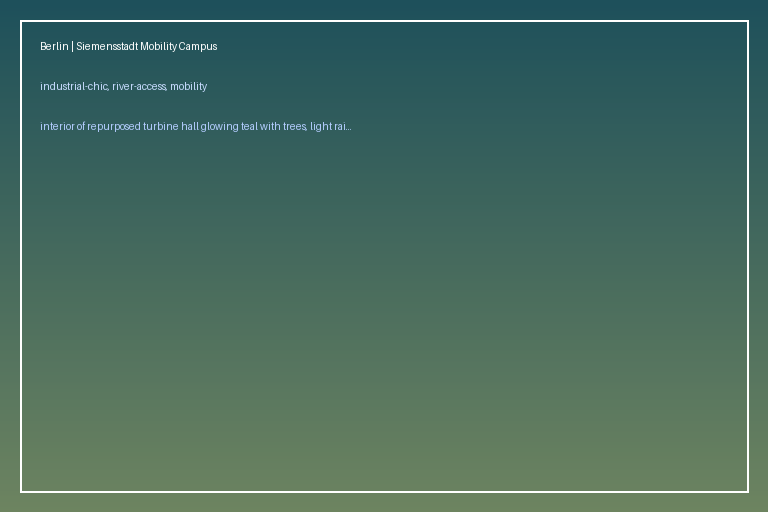

Image preview -> HM-BER-01 (Berlin)


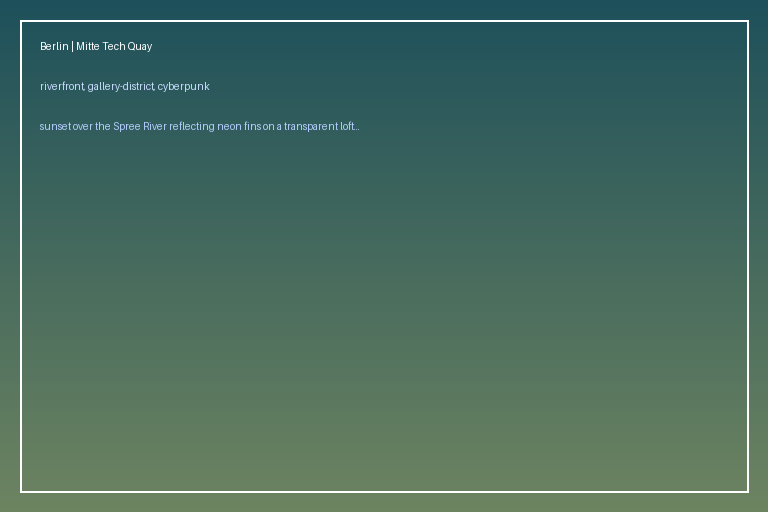

Image preview -> HM-BER-02 (Berlin)


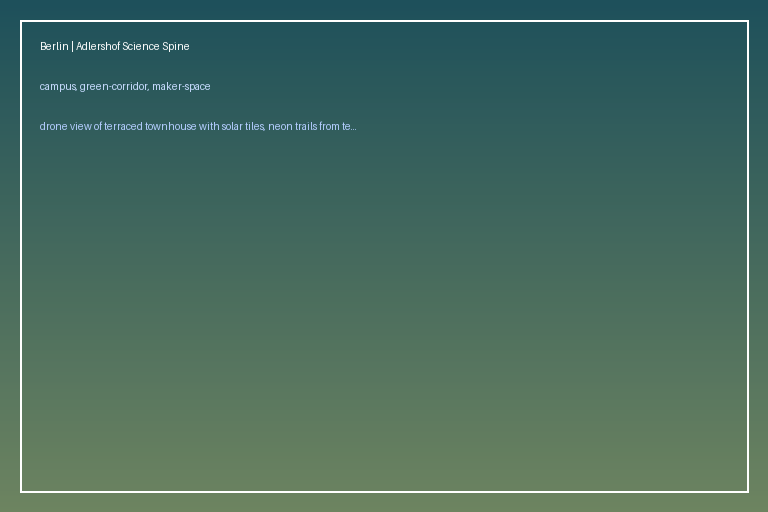

In [17]:
from IPython.display import Image as IPImage, display

for item in ranked_results[:3]:
    listing = item["listing"]
    print(f"Image preview -> {listing.listing_id} ({listing.city})")
    display(IPImage(filename=listing.image_path, width=360))

In [18]:
personalized = personalize_recommendations(ranked_results, high_tech_profile, llm, top_k=12)
for entry in personalized:
    print("-" * 80)
    print(f"{entry['listing_id']} - {entry['city']} - score={entry['score']}")
    print(entry['narrative'])

--------------------------------------------------------------------------------
HM-BER-04 - Berlin - score=0.482
Nestled within the vibrant Siemensstadt2 neighborhood in Berlin, Listing HM-BER-04 offers a truly unique living experience for the Neo-Urban Researcher seeking a cyberpunk-but-green sanctuary. Priced at 1,045,000 EUR, this 2600 sqft home boasts 4 bedrooms and 3 baths, featuring an immersive holo-office, indoor garden canyon, and a futuristic gear elevator. The property is conveniently located near U7 Rohrdamm, Siemens Mobility hydrogen shuttle, and the Cycle superhighway, ensuring seamless connectivity. Technological marvels such as digital twin HVAC, robotic herb wall, and an EV microgrid hub cater to the buyer's innovative lifestyle. Embrace the blend of industrial heritage and modern AI campus living, with climbing gyms, riverwalks, and pop-up science museums enriching the neighborhood. Step into this atrium home carved inside a revitalized turbine hall, where suspended 